# ML Models

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [31]:
import os 

''' Input the directory where your folder created in main.processing.ipynb is located '''
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

''' Where you want the output of this notebook to be placed '''
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

from matplotlib import pyplot
import pandas as pd 
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics as met
from scipy import stats
import json

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


"""
Initial flags and Options that are constant for all models
"""
#Here we set a seed so that our random search produce the same result 
np.random.seed(31415)

# Here we create a scoring dictionary which defines the metrics we report on in cross validation
scoring = {
    'accuracy': met.make_scorer(met.accuracy_score),
    'precision': met.make_scorer(met.precision_score),
    'sensitivity': met.make_scorer(met.recall_score),
    'specificity': met.make_scorer(met.recall_score,pos_label = 0),
    'f1': met.make_scorer(met.f1_score),
    'roc_auc': met.make_scorer(met.roc_auc_score),
    "MCC" : met.make_scorer(met.matthews_corrcoef)
}

# This is the metric we seek to optimise through tuning
refit = "sensitivity"

# Which folder of preprocessed data we want to use
FOLDER_NAME = "Baseline_Approach"

#Whether to print information about the percentage of positive cases in our train and test sets
POSITIVE_CASES_PRINT = 1

#Use this to set the number of CPU threads used for cross validation and tuning
#CV and tuning can be very cpu intensive and if your cpu runs hot, its advised to not run all cores, though the code will take longer to run
CV_TUNING_N_CORES = 4

"""
"""

#Just to stop \n being printed out due to the open strings
clear = 1


#### In this cell we import our training data and drop PATNO and SMOTE helper colums

In [32]:
train = pd.read_csv(FOLDER_NAME + '/train.csv')
FP_DF = pd.read_csv(FOLDER_NAME + '/FP_DF.csv')

#We read our SMOTE helper column into a variable and then drop it
SAMPLING = train.SAMPLING.values[0]
train.drop(["SAMPLING"], axis = 1, inplace = True)

# We form train_FP used for sensitivty vs year plots and then drop PATNO
train_FP = train.merge(FP_DF, how = "inner", on = "PATNO")
train.drop(["PATNO"], axis = 1, inplace = True)


# We form Y
train_Y = train.pop("HALL")



if POSITIVE_CASES_PRINT:
    print("(The number of subjects, number of features) in training set", train.shape)
    print("Number of patients which hallucinates eventually in training set is ",  sum(train_Y), " which is ", sum(train_Y)/ (train_Y.size), " percent of patients")
    
# Used for xgboost class weight balancing
num_pos_samples = sum(train_Y)
num_neg_samples = train_Y.size - num_pos_samples
pos_weights_scale = num_neg_samples / num_pos_samples

(The number of subjects, number of features) in training set (279, 34)
Number of patients which hallucinates eventually in training set is  71  which is  0.25448028673835127  percent of patients


#### In this cell we import our test data (if flag is set) and drop PATNO and SMOTE helper columns

In [33]:
test = pd.read_csv(FOLDER_NAME + '/test.csv')

# We form test_FP used for sensitivity vs year plots and then drop PATNO
test_PATNO = test.pop("PATNO")
test_FP = FP_DF.merge(test_PATNO.to_frame(), how = "inner", on = "PATNO")

# We form Y
test_Y = test.pop("HALL")

if POSITIVE_CASES_PRINT:
    print("(The number of subjects, number of features) in test set", test.shape)
    print("Number of patients which hallucinates eventually in test set is ",  sum(test_Y), " which is ", sum(test_Y)/ (test_Y.size), " percent of patients")


(The number of subjects, number of features) in test set (120, 34)
Number of patients which hallucinates eventually in test set is  31  which is  0.25833333333333336  percent of patients


#### In this cell we define our sampling (SMOTE currently) functions

In [34]:
import imblearn as imbl

def over_sampling(model, X):
    
    categorical_columns = []
    
    for c in X.columns:
        if "C_" in c:
            categorical_columns.append(c)
            
    categorical_columns = [X.columns.get_loc(c) for c in categorical_columns]

    pipeline = imbl.pipeline.make_pipeline(imbl.over_sampling.SMOTENC(categorical_columns, sampling_strategy = 1),
                                          model)
    
    return pipeline

#### In this cell we define a small function for overwrite protection

In [35]:
def overwrite_protection(path_string):
    
    file_name_index = path_string.rfind("/")
    
    #Overwrite protection
    if os.path.exists(path_string):        
        print("File already exists, are you sure you want to overwrite ", path_string[file_name_index + 1:], " in the folder ", path_string[:file_name_index], "?" )
        i = input("Y?:")

        if i != "Y":
            raise ValueError("Y not answered to overwrite, writing to disk cancelled")
        else:
            pass

    

#### In this cell we define general functions for hyperparameter tuning and cross validation using sklearn functions

In [36]:
import copy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def randomized_tuning (X,Y, model, param_dist, k_folds, n_iter, scoring_metrics, scoring_refit, sampling):
    '''
    model should be a XGBClassifier or sklearn classifier 
    param_dist can look like this
    param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
    k_folds = number of folds in CV
    n_iter = number of different random combination of parameters tried. More iterations gives a higher chance of finding the best parameters
    scoring metrics = the metrics the search wil report on a the end, example: ['roc_auc', 'f1']
    scoring_refit = The single metric that will be used to find a "best estimator" at the end,  pick one metric from your scoring metrics list. e.g "f1" or 
    '''
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
            model_string = model.steps[1][0]
            temp_param_dist = copy.deepcopy(param_dist)
            param_dist = {model_string + "__" + key: param_dist[key] for key in param_dist}
                
    clf = RandomizedSearchCV(model, param_distributions = param_dist, cv = StratifiedKFold(n_splits = k_folds, shuffle = True), n_iter = n_iter, scoring = scoring_metrics, refit = scoring_refit, \
                             error_score = 0, verbose = 1, n_jobs = CV_TUNING_N_CORES)

    params = clf.fit(X,Y).best_params_
    if sampling != "NONE":
        params = {key[key.find('_') + 2:]: params[key] for key in params}
        param_dist = temp_param_dist
    
    for k, v in param_dist.items():
        if not isinstance(v, list):
            print("\nFor hyperparameter", k, " possible interval was : [" , v.interval(1)[0], ",", v.interval(1)[1], "]. The value chosen by RandomSearch is: ", params[k])
        else:
            values_string = "["
            for i in v:
                values_string += str(i) + ","
            values_string += "]"
            print("\nFor hyperparameter", k, " possible values were :", values_string,  ". The value chosen by GridSearch is: ", params[k])
    
    print("Optimized for ", scoring_refit)    
    
    return params


def grid_tuning(X,Y, model, param_grid, k_folds, scoring_metrics, scoring_refit, sampling):
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
            model_string = model.steps[1][0]
            temp_param_grid = copy.deepcopy(param_grid)
            param_grid = {model_string + "__" + key: param_grid[key] for key in param_grid}
            
    clf = GridSearchCV(model, param_grid = param_grid, cv = StratifiedKFold(n_splits = k_folds, shuffle = True), scoring = scoring_metrics, refit = scoring_refit, \
                         error_score = 0, verbose = 1, n_jobs = CV_TUNING_N_CORES)
    
    params = clf.fit(X,Y).best_params_
    
    if sampling != "NONE":
        params = {key[key.find('_') + 2:]: params[key] for key in params}
        param_grid = temp_param_grid
        
    for k, v in param_grid.items():
        values_string = "["
        for i in v:
            values_string += str(i) + ","
        values_string += "]"
        print("\nFor hyperparameter", k, " possible values were :", values_string,  ". The value chosen by GridSearch is: ", params[k])
    
    print("Optimized for ", scoring_refit)
    return params


def CV_report (model, X, Y, k_folds, scoring, sampling, return_results = False):
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
        
    cv_results = cross_validate(model, X, Y, cv = StratifiedKFold(n_splits = k_folds, shuffle = True), scoring= scoring, n_jobs = CV_TUNING_N_CORES,  verbose = 1, return_train_score = True)
    
    df = pd.DataFrame(columns = ["Metric", "Train mean", "Train SD", "Test mean", "Test SD"])
    rows_list = []
    for x in scoring:
        score_dict = {}
        score_dict["Metric"] = x
        score_dict["Train mean"] = np.mean(cv_results["train_" + x])
        score_dict["Train SD"] = np.std(cv_results["train_" + x])
        score_dict["Test mean"] = np.mean(cv_results["test_" + x])
        score_dict["Test SD"] = np.std(cv_results["test_" + x])  
        rows_list.append(score_dict)
    
    results = df.append(pd.DataFrame(rows_list), sort = False)
    if return_results:
        return results
    else:
        print("\nCV estimate:")  
        print("\n", results)
        
        
        
def nested_CV_report_random(model, X, Y, param_dist, k_folds, n_iter, scoring, scoring_refit, sampling):
    
    inner_cv = StratifiedKFold(n_splits = k_folds - 1, shuffle = True)
    
    clf = RandomizedSearchCV(model, param_distributions = param_dist, cv = inner_cv, n_iter = n_iter, scoring = scoring, refit = scoring_refit, \
                             error_score = 0, verbose = 1, n_jobs = 1)
    
    results = CV_report(clf, X, Y, k_folds, scoring, sampling, return_results = True)
    
    print("\nNested CV estimate:")  
    print("\n", results)
    
    return results
    
    
def nested_CV_report_grid(model, X, Y, param_grid, k_folds, scoring, scoring_refit, sampling):

    inner_cv = StratifiedKFold(n_splits = k_folds - 1, shuffle = True)
    
    clf = GridSearchCV(model, param_grid = param_grid, cv = inner_cv, scoring = scoring, refit = scoring_refit, \
                             error_score = 0, verbose = 1, n_jobs = 1)
    
    results = CV_report(clf, X, Y, k_folds, scoring, sampling, return_results = True)
    
    print("\nNested CV estimate:")  
    print("\n", results)
    
    return results

#### In this cell we set all flags and parameters for Logistic Regression

In [37]:
'''
Parameters for Logistic Regression can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
'''


'''
    Flags and Parameters for Logistic Regression
'''
# 0 = No, 1 = Yes
ENABLE_LOGISTIC_REGRESSION = 0

#Number of folds to use in CV
LOGISTIC_REGRESSION_K_FOLD = 10

if ENABLE_LOGISTIC_REGRESSION:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK = 1

    if LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #LOGISTIC_REGRESSION_[FILE_NAME].txt
        LOGISTIC_REGRESSION_FILE_NAME = "bestparams"
    
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    LOGISTIC_REGRESSION_TUNING_METHOD = 2
    
    if LOGISTIC_REGRESSION_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        LOGISTIC_REGRESSION_PARAMS = {
            "solver" : "liblinear",
            "class_weight": "balanced",
            "C" : 0.22,
            'penalty' : 'l1'
        }
    
    
    elif LOGISTIC_REGRESSION_TUNING_METHOD != 0:
        
        #Whether or not to use nested in addition to regular CV
        # 0 = No, 1 = Yes
        LOGISTIC_REGRESSION_NESTED_CV = 1
        
        #Use this for parameters that you want to set,but not search through
        LOGISTIC_REGRESSION_PARAMS = {
            "solver" : "liblinear",
            "class_weight": "balanced",
            "n_jobs": 4
            


        }
        
        if LOGISTIC_REGRESSION_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER = 1000
            
            #Use this to define the distributions to search through in randomsearch
            LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH = { 
                'C' : stats.uniform(0.0, 10)
                         }
            
            
        elif LOGISTIC_REGRESSION_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH = {
                'C' : [0.0001,0.001,0.01,0.1]
                
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do our logistic regression

In [38]:
from sklearn.linear_model import LogisticRegression

if ENABLE_LOGISTIC_REGRESSION:
    
    if LOGISTIC_REGRESSION_TUNING_METHOD == 0:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)
        
    if LOGISTIC_REGRESSION_TUNING_METHOD == 1:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        
        if LOGISTIC_REGRESSION_NESTED_CV:
            nested_CV_results = nested_CV_report_random(clf_log, train, train_Y, LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH, \
                    LOGISTIC_REGRESSION_K_FOLD, LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
            
            
            
        
        params = randomized_tuning(train,train_Y,clf_log, LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH, LOGISTIC_REGRESSION_K_FOLD, \
                                   LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS, **params)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)
        

          
        
        
    if LOGISTIC_REGRESSION_TUNING_METHOD == 2:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        if LOGISTIC_REGRESSION_NESTED_CV:
            nested_CV_results = nested_CV_report_grid(clf_log, train, train_Y, LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH, \
                    LOGISTIC_REGRESSION_K_FOLD, scoring, refit, SAMPLING)
        
        params = grid_tuning(train,train_Y,clf_log, LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH, LOGISTIC_REGRESSION_K_FOLD, scoring, refit, SAMPLING)
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS, **params)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)

    if LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK:
        params = clf_log.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/LOGISTIC_REGRESSION_' + LOGISTIC_REGRESSION_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)   
            
        if LOGISTIC_REGRESSION_TUNING_METHOD != 0:    
            if LOGISTIC_REGRESSION_NESTED_CV:
                try:
                    save_string = output_filepath + '/' + FOLDER_NAME + '/LOGISTIC_REGRESSION_' + LOGISTIC_REGRESSION_FILE_NAME + '_NESTED_CV.csv'
                    overwrite_protection(save_string)
                    print("\nSaving nested CV estimate to disk")
                    nested_CV_results.to_csv(save_string, index = False)
                except NameError:
                    pass
            

#### In this cell we set all flags and parameters for Support Vector Machines

In [39]:
'''
Parameters for SVM can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
'''

'''
    Flags and Parameters for Support Vector Machines
'''
# 0 = No, 1 = Yes
ENABLE_SVM = 1

#Number of folds to use in CV
SVM_K_FOLD = 10

if ENABLE_SVM:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    SVM_SAVE_PARAMS_TO_DISK = 1

    if SVM_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #SVM_[FILE_NAME].txt
        SVM_FILE_NAME = "bestparams"
    
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    SVM_TUNING_METHOD = 0
    
    if SVM_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        SVM_PARAMS = {
            "kernel" : "linear",
            "class_weight": "balanced",
            "C" : 3.3
        }

    
    
    elif SVM_TUNING_METHOD != 0:
        #Whether or not to use nested in addition to regular CV
        # 0 = No, 1 = Yes
        SVM_NESTED_CV = 0
        
        #Use this for parameters that you want to set,but not search through
        SVM_PARAMS = {
            "class_weight": "balanced",
            'kernel' : 'linear'
        }
        
        if SVM_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            SVM_RANDOMSEARCH_N_ITER = 1000
            
            #Use this to define the distributions to search through in randomsearch
            SVM_PARAMS_RANDOM_SEARCH = { 
                'C' : stats.uniform(0, 10),
                'gamma' : stats.uniform(0,10),
                'degree' : stats.randint(1,6),
                'coef0' : stats.uniform(0,10)
                
            }
            
            
        elif SVM_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            SVM_PARAMS_GRID_SEARCH = { 
                'C' : np.arange(1, 12.1,0.1)
            }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we apply SVM from scikit-learn

In [40]:
from sklearn import svm

if ENABLE_SVM:
    
    if SVM_TUNING_METHOD == 0:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)
        
    if SVM_TUNING_METHOD == 1:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        
        if SVM_NESTED_CV:
            nested_CV_results = nested_CV_report_random(clf_svm, train, train_Y, SVM_PARAMS_RANDOM_SEARCH, \
                    SVM_K_FOLD, SVM_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        params = randomized_tuning(train,train_Y,clf_svm, SVM_PARAMS_RANDOM_SEARCH, SVM_K_FOLD, \
                                   SVM_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_svm = svm.SVC(**SVM_PARAMS, **params)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)
        
        
        
    if SVM_TUNING_METHOD == 2:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        
        if SVM_NESTED_CV:
            nested_CV_results = nested_CV_report_grid(clf_svm, train, train_Y, SVM_PARAMS_GRID_SEARCH, \
                SVM_K_FOLD, scoring, refit, SAMPLING)
            
        params = grid_tuning(train,train_Y,clf_svm, SVM_PARAMS_GRID_SEARCH, SVM_K_FOLD, scoring, refit, SAMPLING)
        
        clf_svm = svm.SVC(**SVM_PARAMS, **params)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)

    if SVM_SAVE_PARAMS_TO_DISK:
        params = clf_svm.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/SVM_' + SVM_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)
        if SVM_TUNING_METHOD != 0:  
            if SVM_NESTED_CV:
                try:
                    save_string = output_filepath + '/' + FOLDER_NAME + '/SVM_' + SVM_FILE_NAME + '_NESTED_CV.csv'
                    overwrite_protection(save_string)
                    print("\nSaving nested CV estimate to disk")
                    nested_CV_results.to_csv(save_string, index = False)
                except NameError:
                    pass


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.4s finished



CV estimate:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.714863  0.012547   0.630820  0.071430
1    precision    0.460350  0.014131   0.360311  0.071675
2  sensitivity    0.686880  0.055487   0.562500  0.163517
3  specificity    0.724337  0.029427   0.653810  0.108296
4           f1    0.550137  0.018733   0.432367  0.089511
5      roc_auc    0.705609  0.017105   0.608155  0.073491
6          MCC    0.369763  0.026782   0.195806  0.130873
File already exists, are you sure you want to overwrite  SVM_bestparams.txt  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/Baseline_Approach ?


Y?: Y



Saving hyperparameters to disk


#### In this cell we set all flags and parameters for the single decision tree

In [41]:
'''
Parameters for decision tree can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
'''



'''
    Flags and Parameters for the single decision tree
'''
# 0 = No, 1 = Yes
ENABLE_DECISION_TREE = 0

#Number of folds to use in CV
DECISION_TREE_K_FOLD = 10

if ENABLE_DECISION_TREE:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    DECISION_TREE_SAVE_PARAMS_TO_DISK = 1

    if DECISION_TREE_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #DECISION_TREE_[FILE_NAME].txt
        DECISION_TREE_FILE_NAME = "bestparams"
        
    #Use this to show a visual presentation of the decision tree built on the training data
    # 0 = No, 1 = Yes
    DECISION_TREE_PLOT_TREE = 0
    
    if DECISION_TREE_PLOT_TREE:
        
        #Use this to limit what parts of the tree is displayed, useful for most trees
        #Set to None if you want the full tree
        DECISION_TREE_MAX_DEPTH_TO_DISPLAY = 3
        
        #Use this to save the resulting graph to a png image
        # 0 = No, 1 = Yes
        DECISION_TREE_SAVE_VISUALIZATION = 1
        
        if DECISION_TREE_SAVE_VISUALIZATION:
            DECISION_TREE_IMAGE_NAME = "bl_approach"
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    DECISION_TREE_TUNING_METHOD = 0
    
    if DECISION_TREE_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        DECISION_TREE_PARAMS = {
            "criterion" : "gini",
            "splitter" : "best",
            "class_weight" : "balanced",
            "ccp_alpha" : 0.025
        }
    
    
    elif DECISION_TREE_TUNING_METHOD != 0:
        #Whether or not to use nested in addition to regular CV
        # 0 = No, 1 = Yes
        DECISION_TREE_NESTED_CV = 1
        
        #Use this for parameters that you want to set,but not search through
        DECISION_TREE_PARAMS = {
            "criterion" : "gini",
            "splitter" : "best",
            "class_weight" : "balanced",
        }
        
        if DECISION_TREE_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            DECISION_TREE_RANDOMSEARCH_N_ITER = 1000
            
            #Use this to define the distributions to search through in randomsearch
            DECISION_TREE_PARAMS_RANDOM_SEARCH = { 
                "ccp_alpha" : stats.uniform(0,0.05)
             }
            
            
        elif DECISION_TREE_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            DECISION_TREE_PARAMS_GRID_SEARCH = { 
                "ccp_alpha" : np.arange(0.001,0.05,0.001)
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do a decision tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

if ENABLE_DECISION_TREE:
    
    if DECISION_TREE_TUNING_METHOD == 0:
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS)
        CV_report(clf_DT, train, train_Y, DECISION_TREE_K_FOLD, scoring, SAMPLING)
        
    if DECISION_TREE_TUNING_METHOD == 1:
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS)
        
        if DECISION_TREE_NESTED_CV:
            nested_CV_results = nested_CV_report_random(clf_DT, train, train_Y, DECISION_TREE_PARAMS_RANDOM_SEARCH, \
                    DECISION_TREE_K_FOLD, DECISION_TREE_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        
        params = randomized_tuning(train,train_Y,clf_DT, DECISION_TREE_PARAMS_RANDOM_SEARCH, DECISION_TREE_K_FOLD, \
                                   DECISION_TREE_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS, **params)
        CV_report(clf_DT, train, train_Y, DECISION_TREE_K_FOLD, scoring, SAMPLING)
        
        
    if DECISION_TREE_TUNING_METHOD == 2:
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS)
        if DECISION_TREE_NESTED_CV:
            nested_CV_results = nested_CV_report_grid(clf_DT, train, train_Y, DECISION_TREE_PARAMS_GRID_SEARCH, \
                    DECISION_TREE_K_FOLD, scoring, refit, SAMPLING)        
        
        params = grid_tuning(train,train_Y,clf_DT, DECISION_TREE_PARAMS_GRID_SEARCH, DECISION_TREE_K_FOLD, scoring, refit, SAMPLING)
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS, **params)
        CV_report(clf_DT, train, train_Y, DECISION_TREE_K_FOLD, scoring, SAMPLING)

    if DECISION_TREE_SAVE_PARAMS_TO_DISK:
        params = clf_DT.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f) 
        if DECISION_TREE_TUNING_METHOD != 0:  
            if DECISION_TREE_NESTED_CV:
                try:
                    save_string = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_FILE_NAME + '_NESTED_CV.csv'
                    overwrite_protection(save_string)
                    print("\nSaving nested CV estimate to disk")
                    nested_CV_results.to_csv(save_string, index = False)
                except NameError:
                    pass
        
    if DECISION_TREE_PLOT_TREE:
        from IPython.display import SVG
        from graphviz import Source
        from IPython.display import display
        
        labels = train.columns
        
        fit = clf_DT.fit(train,train_Y)
        
        graph = tree.export_graphviz(fit, out_file=None, feature_names=labels, class_names=['Negative', 'Positive'],filled = True, \
                        max_depth = DECISION_TREE_MAX_DEPTH_TO_DISPLAY, proportion = True)
        graph_source = Source(graph)
        display(SVG(graph_source.pipe(format='svg')))
        
        if DECISION_TREE_SAVE_VISUALIZATION:
            save_string = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_IMAGE_NAME + '.pdf'
            overwrite_protection(save_string)
            save_string = save_string[0:-4]
            graph_source.render(save_string) 
            os.remove(save_string)     

#### In this cell we set all flags and parameters for Random Forest

In [43]:
'''
Parameters for Random Forest can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
'''

# 0 = No, 1 = Yes
ENABLE_RANDOM_FOREST = 0

#Number of folds to use in CV
RANDOM_FOREST_K_FOLD = 10

if ENABLE_RANDOM_FOREST:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    RANDOM_FOREST_SAVE_PARAMS_TO_DISK = 1

    if RANDOM_FOREST_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #RANDOM_FOREST_[FILE_NAME].txt
        RANDOM_FOREST_FILE_NAME = "bestparams"
    
    #Use this to show a plot of estimated feature importance found from the trees constructed
    # 0 = No, 1 = Yes
    RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE = 0
    if RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE:
        #As the plot quickly becomes impoosible to read if a lot of features are included in the model
        RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW = 4
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    RANDOM_FOREST_TUNING_METHOD = 0
    
    if RANDOM_FOREST_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        RANDOM_FOREST_PARAMS = {
            "class_weight" : "balanced",
            'max_features' : 0.60,
            'n_estimators' : 114,
            'max_depth' : 1
            

        }
    
    
    elif RANDOM_FOREST_TUNING_METHOD != 0:
        
        #Whether or not to use nested in addition to regular CV
        # 0 = No, 1 = Yes
        RANDOM_FOREST_NESTED_CV = 1    
        
        #Use this for parameters that you want to set,but not search through
        RANDOM_FOREST_PARAMS = {
            "class_weight" : "balanced"
        }
        
        if RANDOM_FOREST_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            RANDOM_FOREST_RANDOMSEARCH_N_ITER = 1000
            
            #Use this to define the distributions to search through in randomsearch
            RANDOM_FOREST_PARAMS_RANDOM_SEARCH = {               
                'n_estimators' : stats.randint(80,100),
                'max_features' : stats.uniform(0.5, 0.4),
                'max_depth' : stats.randint(1,3)
             }
            
            
        elif RANDOM_FOREST_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            RANDOM_FOREST_PARAMS_GRID_SEARCH = {
                'n_estimators' : range(80,120,2),
                'max_features' : np.arange(0.50,0.90,0.05),
                'max_depth' : range(1,3,1)
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do random forest from XGBOOST

In [44]:
from sklearn.ensemble import RandomForestClassifier

if ENABLE_RANDOM_FOREST:
    
    if RANDOM_FOREST_TUNING_METHOD == 0:
        
        clf_RF = RandomForestClassifier(**RANDOM_FOREST_PARAMS)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)
        
    if RANDOM_FOREST_TUNING_METHOD == 1:
        
        clf_RF = RandomForestClassifier(**RANDOM_FOREST_PARAMS)
        if RANDOM_FOREST_NESTED_CV:
            nested_CV_results = nested_CV_report_random(clf_RF, train, train_Y, RANDOM_FOREST_PARAMS_RANDOM_SEARCH, \
                    RANDOM_FOREST_K_FOLD, RANDOM_FOREST_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)        
        
        params = randomized_tuning(train,train_Y,clf_RF, RANDOM_FOREST_PARAMS_RANDOM_SEARCH, RANDOM_FOREST_K_FOLD, \
                                   RANDOM_FOREST_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_RF = RandomForestClassifier(**RANDOM_FOREST_PARAMS, **params)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)
        
        
    if RANDOM_FOREST_TUNING_METHOD == 2:
        
        clf_RF = RandomForestClassifier(**RANDOM_FOREST_PARAMS)
        if RANDOM_FOREST_NESTED_CV:
            nested_CV_results = nested_CV_report_grid(clf_RF, train, train_Y, RANDOM_FOREST_PARAMS_GRID_SEARCH, \
                    RANDOM_FOREST_K_FOLD, scoring, refit, SAMPLING)    
            
        params = grid_tuning(train,train_Y,clf_RF, RANDOM_FOREST_PARAMS_GRID_SEARCH, RANDOM_FOREST_K_FOLD, scoring, refit, SAMPLING)
        
        clf_RF = RandomForestClassifier(**RANDOM_FOREST_PARAMS, **params)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)

    if RANDOM_FOREST_SAVE_PARAMS_TO_DISK:
        params = clf_RF.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/RANDOM_FOREST_' + RANDOM_FOREST_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)
        if RANDOM_FOREST_TUNING_METHOD != 0:
            if RANDOM_FOREST_NESTED_CV:
                try:
                    save_string = output_filepath + '/' + FOLDER_NAME + '/RANDOM_FOREST_' + RANDOM_FOREST_FILE_NAME + '_NESTED_CV.csv'
                    overwrite_protection(save_string)
                    print("\nSaving nested CV estimate to disk")
                    nested_CV_results.to_csv(save_string, index = False)
                except NameError:
                    pass

    if RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE:
        print("Plot of feature importance:")
        
        feature_importance_values = clf_RF.fit(train,train_Y).feature_importances_      
        feature_importance = {}        
        for i,u in enumerate(train.columns):
            feature_importance[u] = feature_importance_values[i] 
            
        feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse = True)}
        
        x, y = zip(*feature_importance.items())
        
        x = x[0:RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW]
        y = y[0:RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW]     
        
        pyplot.figure(figsize=(10, 3))
        pyplot.bar(x,y)


        
        

#### In this cell we set all flags and parameters for boosted trees

In [45]:
'''
Parameters for xgboost can be found here:
https://xgboost.readthedocs.io/en/latest/parameter.html

For sklearn API
num_of_boost_rounds = n_estimators
eta = learning rate
'''



'''
    Flags and Parameters for boosted trees
'''
# 0 = No, 1 = Yes
ENABLE_BOOSTED_TREES = 0

#Number of folds to use in CV
BOOSTED_TREES_K_FOLD = 10

if ENABLE_BOOSTED_TREES:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    BOOSTED_TREES_SAVE_PARAMS_TO_DISK = 1

    if BOOSTED_TREES_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #BOOSTED_TREES_[FILE_NAME].txt
        BOOSTED_TREES_FILE_NAME = "bestparams"
    
     #Use this to show a plot of estimated feature importance found from the trees constructed
    # 0 = No, 1 = Yes
    BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE = 0
    if BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE:
        #As the plot quickly becomes impoosible to read if a lot of features are included in the model
        BOOSTED_TREES_MAX_NUMBER_OF_FEATURES_TO_SHOW = 7
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    BOOSTED_TREES_TUNING_METHOD = 0
    
    if BOOSTED_TREES_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        BOOSTED_TREES_PARAMS = {
            'objective': 'binary:logistic',
            'scale_pos_weight':  pos_weights_scale,
            'n_estimators' : 8,
            'max_depth' : 1,
            'min_child_weight' : 6.46,
            'gamma' : 3.14,
            'subsample' : 0.88,
            'colsample_bytree' : 0.89,
            'learning_rate' : 0.45
        }
    
    
    elif BOOSTED_TREES_TUNING_METHOD != 0:       
        #Whether or not to use nested in addition to regular CV
        # 0 = No, 1 = Yes
        BOOSTED_TREES_NESTED_CV = 1 
        
        
        #Use this for parameters that you want to set,but not search through
        BOOSTED_TREES_PARAMS = {
            'objective': 'binary:logistic',
            'scale_pos_weight' : pos_weights_scale,
            'booster' : 'gbtree',

            
            
            
        }
        
        if BOOSTED_TREES_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            BOOSTED_TREES_RANDOMSEARCH_N_ITER = 1000
            
            #Use this to define the distributions to search through in randomsearch
            BOOSTED_TREES_PARAMS_RANDOM_SEARCH = {
                'n_estimators' : stats.randint(5,15),
                'max_depth' : stats.randint(1,3),
                'min_child_weight' : stats.uniform(5,10),
                'gamma' : stats.uniform(0,5),
                'subsample' : stats.uniform(0.8,0.2),
                'colsample_bytree' : stats.uniform(0.5,0.5),
                'learning_rate' : stats.uniform(0.3,1.7)
                
             }
            
        elif BOOSTED_TREES_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            BOOSTED_TREES_PARAMS_GRID_SEARCH = {
                'n_estimators' : range(5,14,1),
                'max_depth' : [1],
                'min_child_weight' : [0],
                'gamma' : [0.0001],
                'subsample' : [1.0],
                'colsample_bytree' : [1.0],
                'learning_rate' : np.arange(0.3,1.5,0.1)
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do boosted trees from XGBOOST

In [46]:
from xgboost.sklearn import XGBClassifier

if ENABLE_BOOSTED_TREES:
    
    if BOOSTED_TREES_TUNING_METHOD == 0:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)
        
    if BOOSTED_TREES_TUNING_METHOD == 1:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        if BOOSTED_TREES_NESTED_CV:
            nested_CV_results = nested_CV_report_random(clf_BT, train, train_Y, BOOSTED_TREES_PARAMS_RANDOM_SEARCH, \
                    BOOSTED_TREES_K_FOLD, BOOSTED_TREES_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)          
        
        params = randomized_tuning(train,train_Y,clf_BT, BOOSTED_TREES_PARAMS_RANDOM_SEARCH, BOOSTED_TREES_K_FOLD, \
                                   BOOSTED_TREES_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS, **params)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)
        
        
    if BOOSTED_TREES_TUNING_METHOD == 2:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        if BOOSTED_TREES_NESTED_CV:
            nested_CV_results = nested_CV_report_grid(clf_BT, train, train_Y, BOOSTED_TREES_PARAMS_GRID_SEARCH, \
                    BOOSTED_TREES_K_FOLD, scoring, refit, SAMPLING)         
        
        params = grid_tuning(train,train_Y,clf_BT, BOOSTED_TREES_PARAMS_GRID_SEARCH, BOOSTED_TREES_K_FOLD, scoring, refit, SAMPLING)
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS, **params)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)

    if BOOSTED_TREES_SAVE_PARAMS_TO_DISK:
        params = clf_BT.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/BOOSTED_TREES_' + BOOSTED_TREES_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)
        if BOOSTED_TREES_TUNING_METHOD != 0:
            if BOOSTED_TREES_NESTED_CV:
                try:
                    save_string = output_filepath + '/' + FOLDER_NAME + '/BOOSTED_TREES_' + BOOSTED_TREES_FILE_NAME + '_NESTED_CV.csv'
                    overwrite_protection(save_string)
                    print("\nSaving nested CV estimate to disk")
                    nested_CV_results.to_csv(save_string, index = False)
                except NameError:
                    pass


    if BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE:
        print("Plot of feature importance:")
        xgb.plot_importance(clf_BT.fit(train,train_Y), max_num_features = BOOSTED_TREES_MAX_NUMBER_OF_FEATURES_TO_SHOW, importance_type='gain', show_values = False)
        pyplot.show()  
        
        

#### In this cell we define flags and options for getting the final results from tuned models

In [47]:
'''
    Flags and Parameters for final results
'''
# 0 = No, 1 = Yes
ENABLE_FINAL_RESULTS = 1

if ENABLE_FINAL_RESULTS:
    
    #Number of folds used for CV results
    FINAL_RESULTS_K_FOLDS = 10
    
    
    #The metrics that will be reported on
    #These are the metrics we have used before, additional metrics are easily implemented if sklearn has it implemented
    '''
    'accuracy': met.make_scorer(met.accuracy_score),
    'precision': met.make_scorer(met.precision_score),
    'sensitivity': met.make_scorer(met.recall_score),
    'specificity': met.make_scorer(met.recall_score,pos_label = 0),
    'f1': met.make_scorer(met.f1_score),
    'roc_auc': met.make_scorer(met.roc_auc_score),
    "MCC" : met.make_scorer(met.matthews_corrcoef)
    '''
    
    FINAL_RESULTS_METRICS = {
        'accuracy': met.make_scorer(met.accuracy_score),
        'precision': met.make_scorer(met.precision_score),
        'sensitivity': met.make_scorer(met.recall_score),
        'specificity': met.make_scorer(met.recall_score,pos_label = 0),
        'f1': met.make_scorer(met.f1_score),
        'roc_auc': met.make_scorer(met.roc_auc_score),
        "MCC" : met.make_scorer(met.matthews_corrcoef)
    }
                            
    
    
    # 0 = No, 1 = Yes
    REPORT_CV_TRAIN_MEAN = 0
    REPORT_CV_TRAIN_STD = 0

    # 0 = No, 1 = Yes
    REPORT_CV_TEST_MEAN = 0
    REPORT_CV_TEST_STD = 0
    
    #Only used if available
    # 0 = No, 1 = Yes
    REPORT_NESTED_CV_TRAIN_MEAN = 0
    REPORT_NESTED_CV_TRAIN_STD = 0
    
    # 0 = No, 1 = Yes
    REPORT_NESTED_CV_TEST_MEAN = 1
    REPORT_NESTED_CV_TEST_STD = 1

    # For actual train and test data, not CV
    # 0 = No, 1 = Yes
    REPORT_TRAIN = 1
    REPORT_TEST = 1
    
    # 0 = No, 1 = Yes
    PLOT_SENSITVITY_BY_FIRST_PSYCHOSIS_TRAIN = 0
    PLOT_SENSITVITY_BY_FIRST_PSYCHOSIS_TEST = 1
    
    # 0 = No, 1 = Yes
    SHOW_CONFUSION_MATRIX = 1
    PLOT_ROC_CURVE= 1

    
    
    # 0 = No, 1 = Yes
    FINAL_RESULTS_LOGISTIC_REGRESSION = 0
    if FINAL_RESULTS_LOGISTIC_REGRESSION:
        #text file with the params you want to use in the final results
        LOGISTIC_REGRESSION_PARAMS = "bestparams.txt" 
       
    # 0 = No, 1 = Yes
    FINAL_RESULTS_SVM = 1
    if FINAL_RESULTS_SVM:
        #text file with the params you want to use in the final results
        SVM_PARAMS = "bestparams.txt"
        
    # 0 = No, 1 = Yes
    FINAL_RESULTS_DECISION_TREE = 0
    if FINAL_RESULTS_DECISION_TREE:
        #text file with the params you want to use in the final results
        DECISION_TREE_PARAMS = "bestparams.txt"
           
    # 0 = No, 1 = Yes
    FINAL_RESULTS_RANDOM_FOREST = 0
    if FINAL_RESULTS_RANDOM_FOREST:
        #text file with the params you want to use in the final results
        RANDOM_FOREST_PARAMS = "bestparams.txt"
        # 0 = No, 1 = Yes
        REPORT_OOB = 1
        
    # 0 = No, 1 = Yes
    FINAL_RESULTS_BOOSTED_TREES = 0
    if FINAL_RESULTS_BOOSTED_TREES:
        #text file with the params you want to use in the final results
        BOOSTED_TREES_PARAMS = "bestparams.txt"
     
    # 0 = No, 1 = Yes
    #Will be saved as a csv file with the name specified in the currently used folder 
    SAVE_FINAL_RESULTS = 0
        
    if SAVE_FINAL_RESULTS:
        
        FINAL_RESULTS_FILE_NAME = "final_results"
        
        
    

### In this cell we define functions used for our final results

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

def plot_sensitivity_by_year (FP_results):
    
    event_id_to_years = {
    "BL" : "Baseline",
    "V04": "1-Year",
    "V06": "2-Year",
    "V08": "3-Year",
    "V10": "4-Year",
    "V12": "5-Year",
    "V13": "6-Year",
    "V14": "7-Year",
    "V15": "8-Year"   
    }
        
    FP_ratio = {}
    FP_total = {}
        
    for event_id, year in event_id_to_years.items():
        
        correct = np.sum(FP_results.loc[FP_results.FP_EVENT_ID == event_id, "results"])
        total = FP_results.loc[FP_results.FP_EVENT_ID == event_id, "results"].size
        
        ratio = 0
        if total != 0:
            ratio = correct/total
            
        
        FP_ratio [year] = ratio
        FP_total [year] = total
   
    fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(18, 5))
       
    x1, y1 = zip(*FP_ratio.items())
    axes[0].set_ylabel("Sensitivity")
    axes[0].set_xlabel("Year")
    axes[0].bar(x1,y1, color = 'g')
    
    x2, y2 = zip(*FP_total.items())
    axes[1].set_ylim (0,16)
    axes[1].set_ylabel("Positive Subjects")
    axes[1].set_xlabel("Year")
    axes[1].bar(x2,y2, color = 'm')
    
    fig.tight_layout()
    
    
def nested_cv_report_helper_function (rows_list, model_string, cv_report):

    if REPORT_NESTED_CV_TRAIN_MEAN:
        results = { "Result_Type" : model_string + "NESTED_CV_TRAIN_MEAN"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Train mean"].values[0]
            
        rows_list.append(results)
        
    if REPORT_NESTED_CV_TRAIN_STD:
        results = { "Result_Type" : model_string + "NESTED_CV_TRAIN_STD"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Train SD"].values[0]

        rows_list.append(results)
        
        
    if REPORT_NESTED_CV_TEST_MEAN:
        results = { "Result_Type" : model_string + "NESTED_CV_TEST_MEAN"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Test mean"].values[0]

        rows_list.append(results)
        
    if REPORT_NESTED_CV_TEST_STD:
        results = { "Result_Type" : model_string + "NESTED_CV_TEST_STD"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Test SD"].values[0]

        rows_list.append(results)

        
def cv_report_helper_function (rows_list, model_string, cv_report):

    if REPORT_CV_TRAIN_MEAN:
        results = { "Result_Type" : model_string + "CV_TRAIN_MEAN"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Train mean"].values[0]
            
        rows_list.append(results)
        
    if REPORT_CV_TRAIN_STD:
        results = { "Result_Type" : model_string + "CV_TRAIN_STD"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Train SD"].values[0]

        rows_list.append(results)
        
        
    if REPORT_CV_TEST_MEAN:
        results = { "Result_Type" : model_string + "CV_TEST_MEAN"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Test mean"].values[0]

        rows_list.append(results)
        
    if REPORT_CV_TEST_STD:
        results = { "Result_Type" : model_string + "CV_TEST_STD"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Test SD"].values[0]

        rows_list.append(results)
        
        
def scorer_helper_function(y_true,y_pred,scorer_string):
    
    if scorer_string == "accuracy":
        return met.accuracy_score(y_true, y_pred)
    elif scorer_string == "precision":
        return met.precision_score(y_true,y_pred)
    elif scorer_string == "sensitivity":
        return met.recall_score(y_true,y_pred)
    elif scorer_string == "specificity":
        return met.recall_score(y_true,y_pred, pos_label = 0)
    elif scorer_string == "f1":
        return met.f1_score(y_true,y_pred)
    elif scorer_string == "roc_auc":
        return met.roc_auc_score(y_true,y_pred)
    elif scorer_string == "MCC":
        return met.matthews_corrcoef(y_true,y_pred)
        
        
def results_helper_function(rows_list, model_string, model):
    
    if SAMPLING != "NONE":
        if SAMPLING == "SMOTE":
            model = over_sampling(model,train)
     
    fit = model.fit(train,train_Y)
    
    if FINAL_RESULTS_RANDOM_FOREST:
        if REPORT_OOB:
            oob_decision_function = fit.oob_decision_function_
            oob_results = np.argmax(oob_decision_function, axis = 1)
            
            results = { "Result_Type" : model_string + "OOB"}
            
            for k,_ in FINAL_RESULTS_METRICS.items():
                results[k] = scorer_helper_function(train_Y,oob_results,k)
            
            rows_list.append(results)
            
            
    
    if REPORT_TRAIN:
        results_train = fit.predict(train)
        
        results = { "Result_Type" : model_string + "TRAIN"}
        
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = scorer_helper_function(train_Y,results_train,k)
            
        rows_list.append(results)
        
    if REPORT_TEST:
        results_test = fit.predict(test)
               
        results = { "Result_Type" : model_string + "TEST"}
        
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = scorer_helper_function(test_Y, results_test, k)
            
        rows_list.append(results)
        
        
    if PLOT_SENSITVITY_BY_FIRST_PSYCHOSIS_TRAIN:
        
        results = fit.predict(train)
        temp_train_FP = train_FP.copy()
        temp_train_FP ['results'] = results
        print("Sensitivity by year: Train")
        plot_sensitivity_by_year(temp_train_FP)
        
    if PLOT_SENSITVITY_BY_FIRST_PSYCHOSIS_TEST:

        results = fit.predict(test)        
        temp_test_FP = test_FP.copy()
        temp_test_FP ['results'] = results
        print("Sensitivity by year: Test")        
        plot_sensitivity_by_year(temp_test_FP)
        
    if SHOW_CONFUSION_MATRIX:
        
        results = fit.predict(test)
        display(confusion_matrix(test_Y, results))
        
    if PLOT_ROC_CURVE:
        
        results = fit.predict(test)
        
        fpr, tpr, tresholds = roc_curve (test_Y, results)
        roc_auc = met.roc_auc_score(test_Y,results)
        
        # Code inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        pyplot.figure()
        lw = 2
        pyplot.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        pyplot.xlim([0.0, 1.0])
        pyplot.ylim([0.0, 1.05])
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.legend(loc="lower right")
        pyplot.show()

### In this section we get our final results as dictated by the flags set

Sensitivity by year: Test


array([[63, 26],
       [12, 19]], dtype=int64)

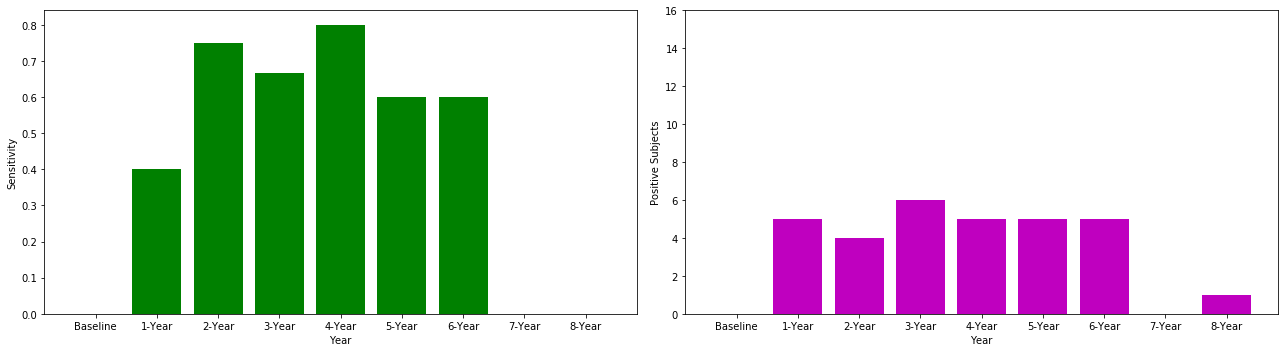

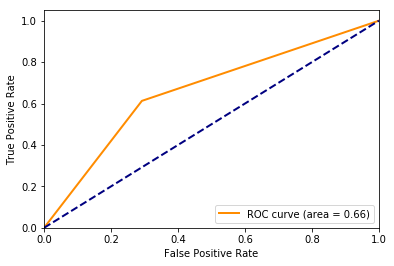

,Result_Type,accuracy,precision,sensitivity,specificity,f1,roc_auc,MCC
0,SVM_NESTED_CV_TEST_MEAN,0.627,0.354,0.562,0.649,0.430,0.606,0.190
1,SVM_NESTED_CV_TEST_STD,0.068,0.069,0.164,0.098,0.091,0.077,0.135
2,SVM_TRAIN,0.720,0.465,0.662,0.740,0.547,0.701,0.365
3,SVM_TEST,0.683,0.422,0.613,0.708,0.500,0.660,0.290


In [48]:

if ENABLE_FINAL_RESULTS:
    
    columns = ["Result_Type"]
    for k,_ in FINAL_RESULTS_METRICS.items():
        columns.append(k)
    
    
    df = pd.DataFrame(columns = columns)
    rows_list = []
    
    if FINAL_RESULTS_LOGISTIC_REGRESSION:
        filepath = output_filepath + '/' + FOLDER_NAME + '/LOGISTIC_REGRESSION_' + LOGISTIC_REGRESSION_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)
        
        clf_log = LogisticRegression(**params)
        
        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:
            
            results = CV_report(clf_log, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "LOGISTIC_REGRESSION_", results)
            
        if REPORT_NESTED_CV_TRAIN_MEAN or REPORT_NESTED_CV_TRAIN_STD or REPORT_NESTED_CV_TEST_MEAN or REPORT_NESTED_CV_TEST_STD:
            
            try:
                results = pd.read_csv(filepath[0:-4] + '_NESTED_CV.csv')
                nested_cv_report_helper_function(rows_list, "LOGISTIC_REGRESSION_", results)
            except:
                pass
            
        results_helper_function(rows_list, "LOGISTIC_REGRESSION_", clf_log)
        
    if FINAL_RESULTS_SVM:
        filepath = output_filepath + '/' + FOLDER_NAME + '/SVM_' + SVM_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)
        
        clf_svm = svm.SVC(**params)
        
        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:
            
            results = CV_report(clf_svm, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "SVM_", results)
            
        if REPORT_NESTED_CV_TRAIN_MEAN or REPORT_NESTED_CV_TRAIN_STD or REPORT_NESTED_CV_TEST_MEAN or REPORT_NESTED_CV_TEST_STD:
            
            try:
                results = pd.read_csv(filepath[0:-4] + '_NESTED_CV.csv')
                nested_cv_report_helper_function(rows_list, "SVM_", results)
            except:
                pass
        
        results_helper_function(rows_list, "SVM_", clf_svm)   
            
     
    if FINAL_RESULTS_DECISION_TREE:
        filepath = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)

        clf_DT = DecisionTreeClassifier(**params)

        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:

            results = CV_report(clf_DT, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "DECISION_TREE_", results)
            
        if REPORT_NESTED_CV_TRAIN_MEAN or REPORT_NESTED_CV_TRAIN_STD or REPORT_NESTED_CV_TEST_MEAN or REPORT_NESTED_CV_TEST_STD:
            
            try:
                results = pd.read_csv(filepath[0:-4] + '_NESTED_CV.csv')
                nested_cv_report_helper_function(rows_list, "DECISION_TREE_", results)
            except:
                pass
            
        results_helper_function(rows_list, "DECISION_TREE_", clf_DT)   


    if FINAL_RESULTS_RANDOM_FOREST:
        filepath = output_filepath + '/' + FOLDER_NAME + '/RANDOM_FOREST_' + RANDOM_FOREST_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)
        
        if REPORT_OOB:
            params['oob_score'] = True
        
        clf_RF = RandomForestClassifier(**params)
    

        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:

            results = CV_report(clf_RF, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "RANDOM_FOREST_", results)
            
        if REPORT_NESTED_CV_TRAIN_MEAN or REPORT_NESTED_CV_TRAIN_STD or REPORT_NESTED_CV_TEST_MEAN or REPORT_NESTED_CV_TEST_STD:
            
            try:
                results = pd.read_csv(filepath[0:-4] + '_NESTED_CV.csv')
                nested_cv_report_helper_function(rows_list, "RANDOM_FOREST_", results)
            except:
                pass
            
        results_helper_function(rows_list, "RANDOM_FOREST_", clf_RF)   
    
    
    if FINAL_RESULTS_BOOSTED_TREES:
        filepath = output_filepath + '/' + FOLDER_NAME + '/BOOSTED_TREES_' + BOOSTED_TREES_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)

        clf_BT = XGBClassifier(**params)

        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:

            results = CV_report(clf_BT, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "BOOSTED_TREES_", results)
            
        if REPORT_NESTED_CV_TRAIN_MEAN or REPORT_NESTED_CV_TRAIN_STD or REPORT_NESTED_CV_TEST_MEAN or REPORT_NESTED_CV_TEST_STD:
            
            try:
                results = pd.read_csv(filepath[0:-4] + '_NESTED_CV.csv')
                nested_cv_report_helper_function(rows_list, "BOOSTED_TREES_", results)
            except:
                pass
            
        results_helper_function(rows_list, "BOOSTED_TREES_", clf_BT)      
    
    
   
    results = df.append(pd.DataFrame(rows_list), sort = False)
                
    display(results.round(3))        
            
       
    if SAVE_FINAL_RESULTS:
        save_string = output_filepath + '/' + FOLDER_NAME + '/' + FINAL_RESULTS_FILE_NAME + '.csv'
        overwrite_protection(save_string)
        print("\nSaving results to disk")
        results.to_csv(save_string, index = False)